Key Components:
1.	State Management: Using TypedDict define and manage state of each customer
2.	Query Categorization: Classify customers queries into Technical, Billing and General categories
3.	Sentiment Analysis: Determine the emotion of customers queries
4.	Response Generation: Create appropriate response on the basis of query category and sentiment
5.	Escalation Mechanism: Automatically escalation negative queries with negative sentiment to human agents
6.	 Workflow Graph: Utilizing LangGraph to create a flexible and extensible workflow  

Method Detailing:
1.	Initialization: Set up the environment and important libraries
2.	State Definition: Create a structure to hold query information, category, sentiment, and response
3.	Node Function: Implement separate Function for categorization, sentiment Analysis and response generation
4.	Graph Construction: Use state Graph to define the workflow, adding nodes and edges to represent the support process
5.	Conditional Routing: Implement logic to route the queries based on their category and sentiment
6.	Workflow Compilation: Compile the graph into an executable application
7.	Execution: Process customer queries through the workflow and retrieve results  


In [1]:
# important libraries
%pip install --quiet -U langchain_google_genai langchain_core langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.2/137.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 979.0 kB/s eta 0:00:00


In [2]:
# set google api key
from google.colab import userdata
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

In [13]:
from typing import TypedDict, Dict
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph.state import CompiledStateGraph


In [14]:
#state and schema setting
from langchain_google_genai import ChatGoogleGenerativeAI
class State(TypedDict):
    query: str
    category: str
    sentiment: str
    response: str

In [15]:
#chat model configure
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key = GEMINI_API_KEY)


In [16]:
## Define Nodes
def categorize(state: State) -> State:
    "Techanical, Billing, General"
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following customer's quiery into one of the category : "
        "Techanical, Billing, General. Query: {query} "
    )
    chain = prompt | llm
    category = chain.invoke({"query": state['query']}).content
    return {"category" : category}

def analyze_sentiment(state: State) -> State:
    prompt = ChatPromptTemplate.from_template(
        "Analyze the sentimetn of the following customer queties"
        "Response with either 'Positive','Neutral' or 'Negative'query: {query}"
    )
    chain = prompt | llm
    sentiment = chain.invoke({"query": state['query']}).content
    return {"sentiment" : sentiment}

def handle_techanical(state: State) -> State:
    prompt = ChatPromptTemplate.from_template(
        "Provide techanical support response to the following query : {query}"
    )
    chain = prompt | llm
    response = chain.invoke({"query": state['query']}).content
    return {"response" : response}

def handle_billing(state: State) -> State:
    prompt = ChatPromptTemplate.from_template(
        "Provide billing support response to the following query : {query}"
    )
    chain = prompt | llm
    response = chain.invoke({"query": state['query']}).content
    return {"response" : response}

def handle_general(state: State) -> State:
    prompt = ChatPromptTemplate.from_template(
        "Provide general support response to the following query : {query}"
    )
    chain = prompt | llm
    response = chain.invoke({"query": state['query']}).content
    return {"response" : response}


def escalate(state: State) -> State:
    return {"response" : "this query has been escalated to a human agent due to its negative sentiment"}


def route_query(state: State) -> State:
    if state['sentiment'] == 'Negative':
        return "escalate"
    elif state['category'] == 'Techanical':
        return 'handle_techanical'
    elif state['category'] == 'Billing':
        return 'handle_billing'
    else:
        'handle_general'

In [17]:
# nodes and edges
workflow = StateGraph(State)

workflow.add_node("categorize", categorize)
workflow.add_node("analyze_sentiment", analyze_sentiment)
workflow.add_node("handle_techanical", handle_techanical)
workflow.add_node("handle_billing", handle_billing)
workflow.add_node("handle_general", handle_general)
workflow.add_node("escalate", escalate)

workflow.add_edge("categorize", "analyze_sentiment")

workflow.add_conditional_edges(
    "analyze_sentiment",route_query
)

workflow.add_edge("handle_techanical", END)
workflow.add_edge("handle_billing", END)
workflow.add_edge("handle_general", END)
workflow.add_edge("escalate", END)

workflow.set_entry_point("categorize")


graph = workflow.compile()

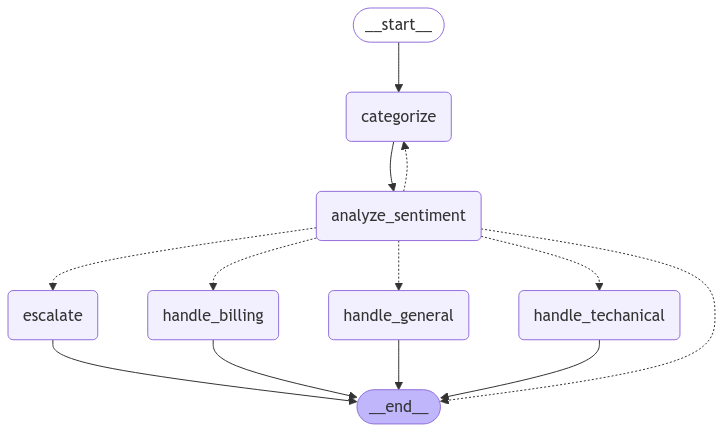

In [30]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
def run_customer_support(query: str) -> Dict[str, str]:
    """Process a customer query through the LangGraph workflow.

    Args:
        query (str): The customer's query

    Returns:
        Dict[str, str]: A dictionary containing the query's category, sentiment, and response
    """
    results = graph.invoke({"query": query})
    return {
        "category": results["category"],
        "sentiment": results["sentiment"],
        "response": results["response"]
    }

Test the Customer Support Agent

In [22]:
# escalate

query = "My internet connection keeps dropping. Can you help?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")


Query: My internet connection keeps dropping. Can you help?
Category: Technical
Sentiment: Negative
Response: this query has been escalated to a human agent due to its negative sentiment




In [28]:
# handle_billing

query = "where can i find my receipt?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")



Query: where can i find my receipt?
Category: Billing
Sentiment: Neutral
Response: Several options exist for finding your receipt, depending on how you paid and when the purchase was made.  Please tell me:

* **How did you pay?** (e.g., credit card, debit card, PayPal, check, cash)
* **Approximately when was the purchase made?** (e.g., date or month)
* **What was the purchase for?** (This helps us narrow down the search if you have multiple invoices.)

Once I have this information, I can guide you to the correct location for your receipt, which may include:

* **Your email inbox:** Check your inbox for an email from us containing your receipt.  Please check your spam or junk folder as well.
* **Your online account:** If you have an account with us, you can usually view and download your receipts from your account history.
* **Our website:** You may be able to access your receipts through our website's order history section. (Provide a link if applicable)
* **Your physical mail:** If yo